# Example notebook for classification analysis

This notebook contains an example analysis of WatChMaL classification runs, including comparison to fiTQun reconstruction.

Plots are included of the training progression, ROC curves, and various plots of signal or background efficiency vs physical quantities.

## Imports and setup

First change some display settings for the notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

External imports:

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import pandas as pd
import sys
import h5py
import tabulate

In [4]:
# either add WatChMaL repository directory to PYTHONPATH environment variable or add it here
sys.path.append('/home/Antoine.m/WatChMaL')
sys.path.append('/home/Antoine.m')

Import WatChMaL analysis code

In [5]:
import analysis.utils.math as math
from analysis.utils.binning import get_binning, apply_binning
from analysis.utils.plotting import plot_legend
from analysis.classification import WatChMaLClassification, FiTQunClassification, plot_rocs, plot_efficiency_profile, combine_softmax
from analysis.read import FiTQunOutput

/home/Antoine.m/WatChMaL/analysis/__init__.py:4: UserWarning: WARNING: The git repository has uncommitted changes. Please commit changes before running WatChMaL code for proper version control
  print(f"Imported analysis code from WatChMaL repository with git version: {get_git_version(os.path.dirname(__file__))}")


Imported analysis code from WatChMaL repository with git version: 2f6e34e-dirty


# Preparing data

In [6]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

## Get true particle data from h5 file

In [7]:
# list of particle names to use in filename
particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3

In [8]:
# get indices of test events
idxs_path = '/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/index_lists/4class_e_mu_gamma_pi0/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
test_idxs  =  np.load(idxs_path, allow_pickle=True)['test_idxs']
train_idxs  =  np.load(idxs_path, allow_pickle=True)['train_idxs']

In [9]:
test_idxs

array([ 2944634,  2944635,  2944636, ..., 21565278, 21565279, 21565280])

### Open H5 data

In [10]:
# open h5 file and get data for test events
data_path = "/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()

In [30]:
def load(test_idxs):
    # open h5 file and get data for test events
    data_path = "/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
    h5_file = h5py.File(data_path, "r")
    h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
    h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
    h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
    h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
    h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
    h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
    h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()
    events_hits_index = np.append(h5_file['event_hits_index'], h5_file['hit_pmt'].shape[0])
    h5_nhits      = (events_hits_index[test_idxs+1] - events_hits_index[test_idxs]).squeeze()
    plt.hist(h5_nhits)
    print(np.mean(h5_nhits))

1328.4657338423563


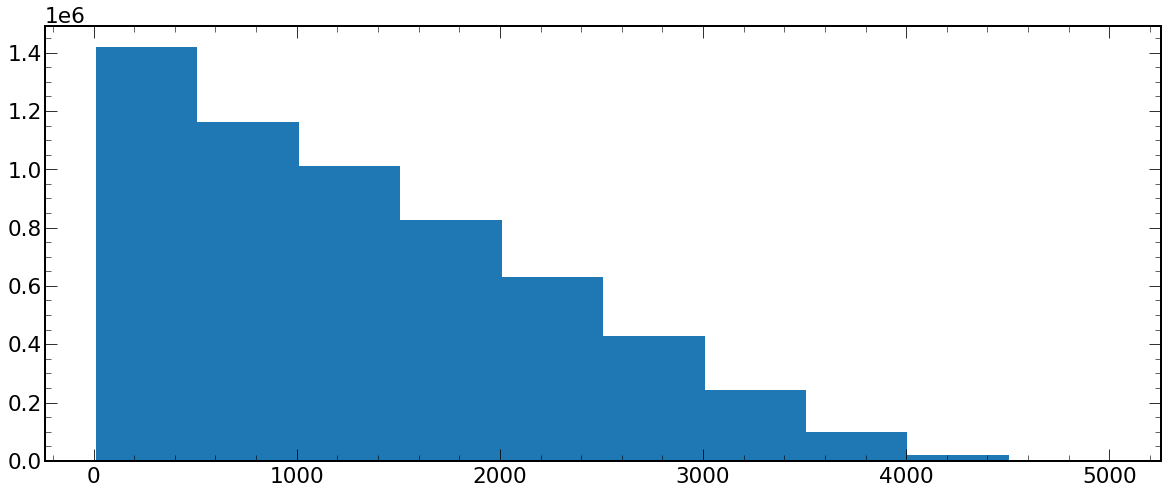

In [31]:
load(train_idxs)

In [13]:
h5_directions = math.direction_from_angles(h5_angles)

(array([1.129536e+06, 9.257630e+05, 8.071620e+05, 6.587840e+05,
        5.051710e+05, 3.469320e+05, 1.985990e+05, 8.151400e+04,
        1.712500e+04, 9.340000e+02]),
 array([  11. ,  507.5, 1004. , 1500.5, 1997. , 2493.5, 2990. , 3486.5,
        3983. , 4479.5, 4976. ]),
 <BarContainer object of 10 artists>)

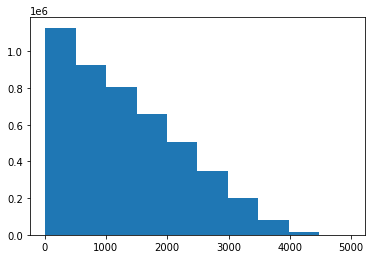

In [14]:
plt.hist(h5_nhits)

# Plotting fiTQun and ResNet performance

## Set up plotting style

In [15]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
rcparams = {
    "font.sans-serif": ["TeX Gyre Heros", "Helvetica", "Arial"],
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (20,8),
    "font.size": 26,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "legend.frameon": False,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
    "xaxis.labellocation": "right",
    "yaxis.labellocation": "top",
}
for key in list(rcparams.keys()):
    matplotlib.rcParams[key] = rcparams[key]
# matplotlib.rcParams['figure.figsize'] = (12, 9)
# matplotlib.rcParams["figure.autolayout"] = True

## Make some cuts to select the events of interest

In [16]:
h5_towall = math.towall(h5_positions, h5_angles)
h5_dwall = math.dwall(h5_positions)
h5_momentum = math.momentum_from_energy(h5_energies, h5_labels)

od_veto_cut = (h5_vetos == 0)
dwall_cut = h5_dwall > 50
towall_cut = h5_towall > 100
nhit_cut = h5_nhits > 25

h5_gammas = (h5_labels==0)
h5_electrons = (h5_labels==1)
h5_muons = (h5_labels==2)
h5_pions = (h5_labels==3)
# select the true electron and muon events that pass the cuts
cuts = ((h5_electrons | h5_muons)
        & od_veto_cut
        & nhit_cut
       )
cut_eff = (od_veto_cut & nhit_cut & towall_cut & dwall_cut)

## Bin events in various quantities

Here we use the binning functions that allow us to bin events by various quantities:

In [17]:
help(get_binning)

Help on function get_binning in module analysis.utils.binning:

get_binning(x, bins=None, minimum=None, maximum=None, width=None)
    Finds the indices of the bins to which each value in input array belongs, for a set of bins specified either as an
    array of bin edges, number of bins or bin width
    
    Parameters
    ----------
    x: array_like
        Input array to be binned.
    bins: array_like, optional
        If `bins` is an int, it defines the number of equal-width bins in the range (200, by default). If `bins` is an
        array, it is the array of bin edges and must be 1-dimensional and monotonic.
    minimum: int or real, optional
        Lowest bin lower edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    maximum: int or real, optional
        Highest bin upper edge (by default use minimum value in `x`). Not used if `bins` is an ndarray of bin edges.
    width: int or real, optional
        Width of bins to generate equal w

In [18]:
mom_binning = get_binning(h5_momentum, 17, 150, 1000)
cos_zenith_binning = get_binning(np.cos(h5_angles[:,0]), 20, -1, 1)
azimuth_binning = get_binning(h5_angles[:,1]*180/np.pi, 20, -180, 180)
dwall_binning = get_binning(h5_dwall, 22, 50, 300)
towall_binning = get_binning(h5_towall, 30, 50, 800)

In [19]:
print(mom_binning)

(array([ 150.,  200.,  250.,  300.,  350.,  400.,  450.,  500.,  550.,
        600.,  650.,  700.,  750.,  800.,  850.,  900.,  950., 1000.]), array([ 2, 15, 17, ...,  9,  6, 18]))


# Electron vs muon

## Load results
### Load ResNet and fiTQun results

Here we set up an instance of the classification class for WatChMaL outputs:

In [20]:
vmdls_run = WatChMaLClassification("/home/Antoine.m/WatChMaL/outputs/2023-05-15/10-27-59", "VMDLS",
                                    h5_labels, test_idxs, cuts, color="blue", linestyle='-')
resnet_run = WatChMaLClassification("/home/pdeperio/machine_learning/data/IWCD_mPMT_Short/WatChMaL/outputs/2022-06-13/09-25-53", "Resnet",
                                    h5_labels, test_idxs, cuts, color="red", linestyle='-')

In [21]:
eval_path = "/home/Antoine.m/WatChMaL/outputs/2023-05-19/20-20-30"
dict_labels = {0.0 : "electron", 1.0 : "gamma", 2.0:"muon", 3.0: "pion"}

In [22]:
df = pd.read_csv(eval_path + "/outputs/log_eval.csv")

In [23]:
df['energies'] = h5_energies
df["zenith"] = h5_angles[:,0]
df["azimuth"] = h5_angles[:,1]
df["towall"] = h5_towall
df["dwall"] = h5_dwall
df["nhits"] = h5_nhits
#df.replace({"labels": dict_labels})

In [24]:
df_cut = df[cut_eff]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

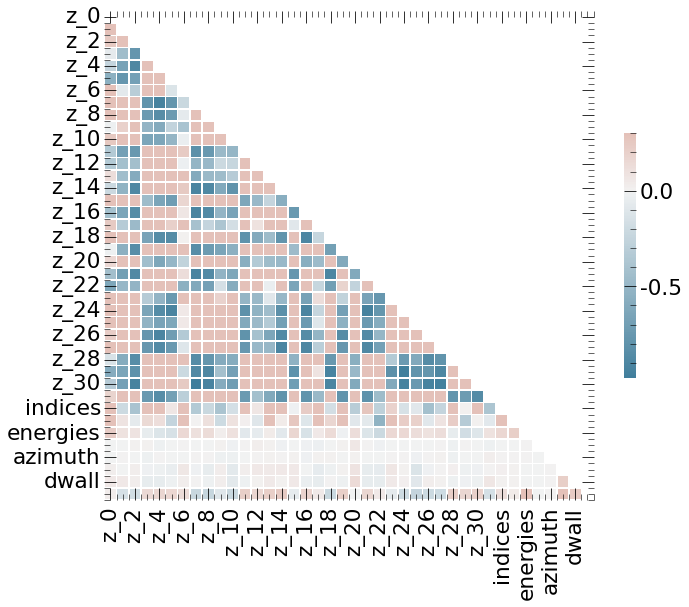

In [25]:
import seaborn as sns
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
from notebooks.tsne_clustering import TSNEclustering

Starting Dimensionality reduction


/home/Antoine.m/my_env/lib64/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


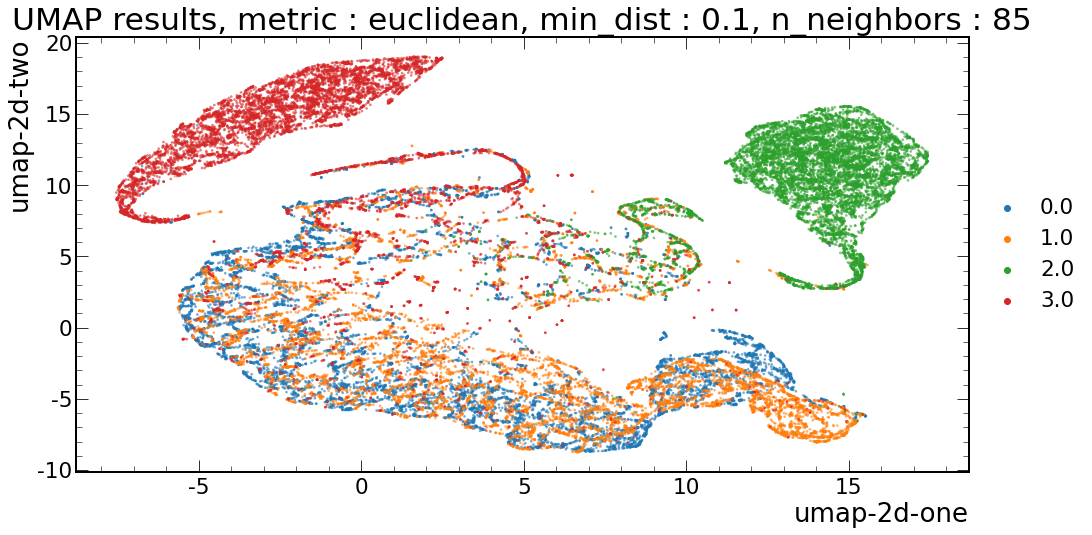

/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


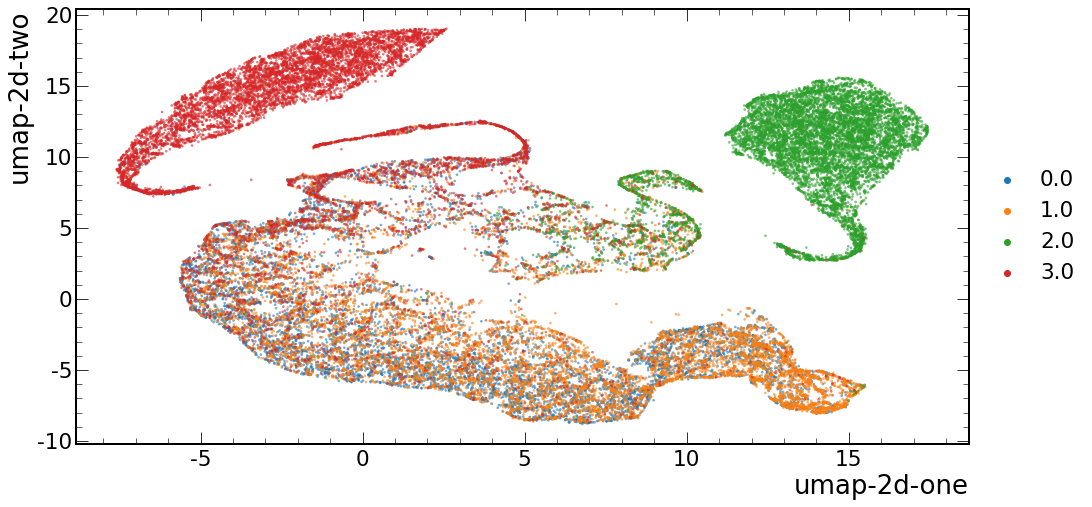

In [27]:
tsne_cl = TSNEclustering(lat_df = df, sample_size= 10000)
metrics = ["euclidean", "manhattan", "chebyshev", "minkowski", "canberra", "braycurtis", "mahalanobis", "wminkowski" ,"seuclidean"]
n_neighbors = [i for i in range(5,101,10)]
min_dist = [0.1, 0.001, 0.01, 0.5]
metrics2 = [ "cosine", "correlation", "haversine", "hamming", "jaccard", "dice", "russelrao", "kulsinski", "ll_dirichlet", "hellinger", "rogerstanimoto", "sokalmichener", "sokalsneath", "yule"]
best_metric = ["euclidean", "chebyshev", "minkowski", "mahalanobis", "braycurtis", "russelrao", "sokalmichener" ]

dist = 0.1
n_neighbor = 85
metric = "euclidean"

tsne_cl.perform_umap(metric = metric, n_neighbors = n_neighbor, min_dist = dist, supervised = True)
#small_df = tsne_cl.get_df()
plot_title = "UMAP results, metric : {0}, min_dist : {1}, n_neighbors : {2}".format(metric, dist, n_neighbor)
tsne_cl.plot_result_train()
plt.title(plot_title)
plt.show()
plt.clf()
tsne_cl.plot_result_test()
# for metric in best_metric :
#     for dist in min_dist :
#         for n_neighbor in n_neighbors:
    
#             tsne_cl.perform_umap(metric = metric, n_neighbors = n_neighbor, min_dist = dist, supervised = False)
#             #small_df = tsne_cl.get_df()
#             plot_title = "UMAP results, metric : {0}, min_dist : {1}, n_neighbors : {2}".format(metric, dist, n_neighbor)
#             tsne_cl.plot_result()
#             plt.title(plot_title)
#             plt.show()
#             plt.clf()


/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


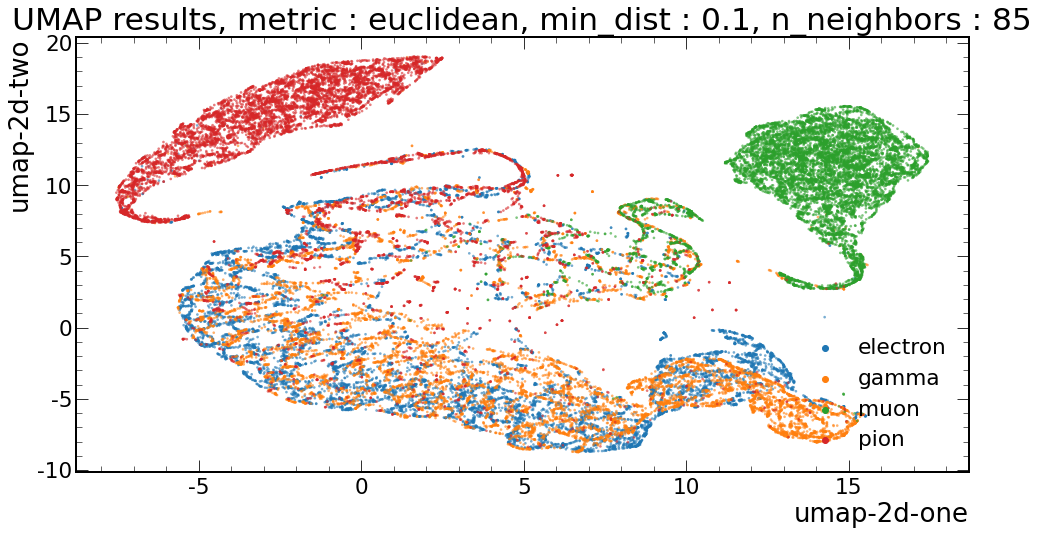

<Figure size 1440x576 with 0 Axes>

In [28]:
tsne_cl.plot_result_train()
plt.title(plot_title)
plt.legend(labels = ["","electron", "gamma", "muon", "pion"])
plt.show()
plt.clf()

Starting Dimensionality reduction


/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


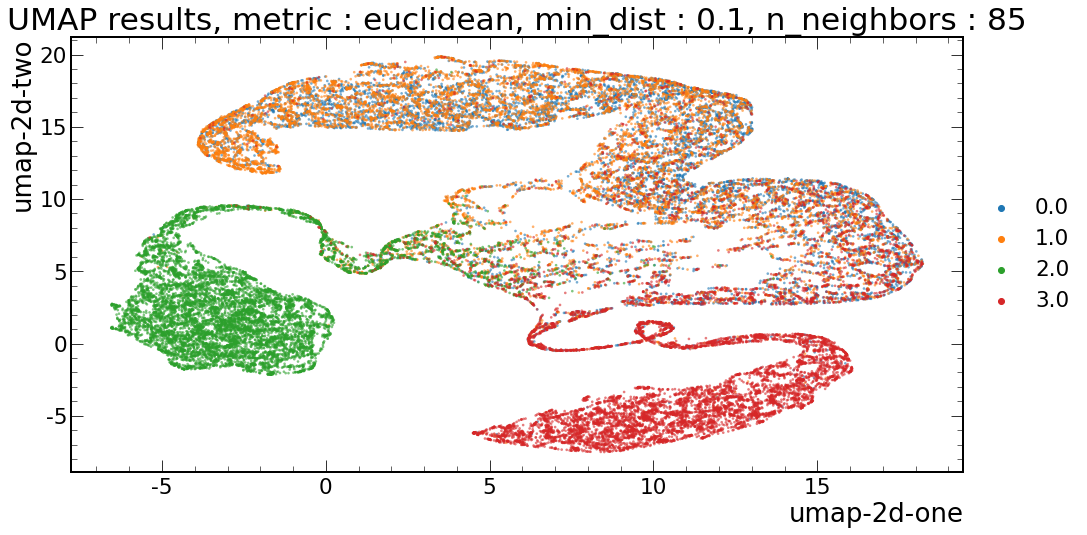

KeyboardInterrupt: 

<Figure size 1440x576 with 0 Axes>

In [29]:
tsne_cl = TSNEclustering(lat_df = df, sample_size= 10000)
metrics = ["euclidean", "manhattan", "chebyshev", "minkowski", "canberra", "braycurtis", "mahalanobis", "wminkowski" ,"seuclidean"]
n_neighbors = [i for i in range(5,101,10)]
min_dist = [0.1, 0.001, 0.01, 0.5]
metrics2 = [ "cosine", "correlation", "haversine", "hamming", "jaccard", "dice", "russelrao", "kulsinski", "ll_dirichlet", "hellinger", "rogerstanimoto", "sokalmichener", "sokalsneath", "yule"]
best_metric = ["euclidean", "chebyshev", "minkowski", "mahalanobis", "braycurtis", "russelrao", "sokalmichener" ]

dist = 0.1
n_neighbor = 85
metric = "euclidean"

tsne_cl.perform_umap(metric = metric, n_neighbors = n_neighbor, min_dist = dist, supervised =False)
#small_df = tsne_cl.get_df()
plot_title = "UMAP results, metric : {0}, min_dist : {1}, n_neighbors : {2}".format(metric, dist, n_neighbor)
tsne_cl.plot_result_train()
plt.title(plot_title)
plt.show()
plt.clf()
tsne_cl.plot_result_test()

In [ ]:
#tsne_cl.lat_df = tsne_cl.lat_df.replace({"labels":dict_labels})
#tsne_cl.plot_result()
small_df = tsne_cl.get_df()


In [ ]:
small_df

index       z_0       z_1       z_2       z_3       z_4       z_5  \
0            0 -0.000574 -0.000484  0.000907 -0.000248  0.000514  0.001435   
1            1 -0.000136  0.000049 -0.000102  0.000091  0.000399  0.000782   
2            2  0.000070 -0.000134 -0.001175  0.000713  0.002139  0.000180   
3            3  0.000130  0.000432  0.000586  0.000095  0.000606  0.000720   
4            4 -0.000190 -0.000041 -0.000062 -0.000137  0.000255  0.000179   
...        ...       ...       ...       ...       ...       ...       ...   
9996   3534478  0.000678 -0.000775 -0.000640  0.000443  0.003453  0.000341   
9997   3534479  0.000321  0.000369 -0.000546  0.000026  0.001392  0.000666   
9998   3534480  0.000682 -0.000532 -0.000406  0.001001  0.002431  0.001051   
9999   3534481 -0.000586 -0.001513  0.001527 -0.000036  0.001172  0.001690   
10000  3534482  0.000952 -0.000192 -0.000861  0.000784  0.001913  0.001264   

            z_6       z_7       z_8  ...    labels    energies    zenith  \
0     -0.232324 -0.000135  0.000266  ...  electron  245.777588  2.380216   
1     -0.112537 -0.001704 -0.001169  ...  electron  858.386841  2.396345   
2      0.271122 -0.003308 -0.000917  ...  electron  984.556030  0.719032   
3     -0.192168 -0.000728 -0.000709  ...  electron  818.989197  1.234110   
4     -0.167949 -0.001241 -0.000732  ...  electron   60.207409  1.387609   
...         ...       ...       ...  ...       ...         ...       ...   
9996   0.728113 -0.004317 -0.000879  ...      pion  250.969711  2.782866   
9997   0.128315 -0.001349 -0.001348  ...      pion  673.177979  0.255284   
9998   0.674619 -0.002501 -0.000447  ...      pion  180.882217  2.168580   
9999   0.140225  0.000901  0.001544  ...      pion  836.143982  2.166463   
10000  0.702487 -0.002951 -0.000892  ...      pion  490.418365  2.653378   

        azimuth      towall       dwall  nhits    cut  tsne-2d-one  \
0     -2.014716  190.761574   64.608521    846   True    -1.483567   
1     -1.009569  158.604782   99.009644    863   True    15.028394   
2     -1.875060   41.012970   30.859924    479  False     4.393330   
3      1.671546  417.253355  121.900787   2902   True    14.753753   
4      0.267695   78.351025   74.096588    240  False    40.037170   
...         ...         ...         ...    ...    ...          ...   
9996   2.435509  396.807495   77.339630   1228   True   -75.259514   
9997  -2.926463  273.867065  157.837906   2280   True    -0.406133   
9998   2.617523  354.493959  190.035477    996   True   -65.493507   
9999  -2.188992  841.045962    0.422638   2680  False    -1.362811   
10000 -2.831330  583.646790    3.029297   2056  False   -70.605240   

       tsne-2d-two  
0       -68.533592  
1        59.848557  
2        32.675594  
3       -45.515816  
4       -39.388062  
...            ...  
9996    -17.639750  
9997    -30.562304  
9998     20.982193  
9999    -28.827932  
10000   -13.021823  

[40004 rows x 44 columns]

/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


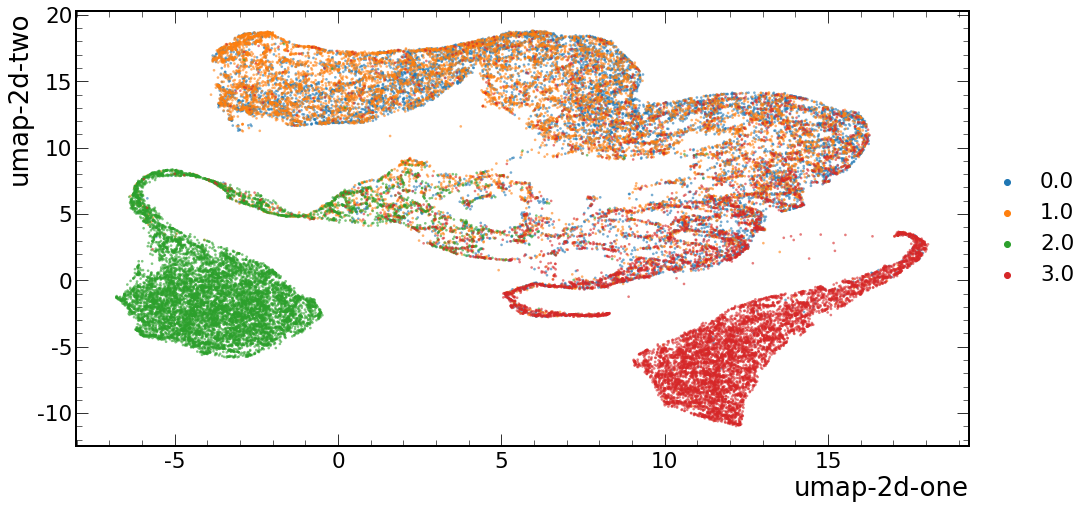

/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


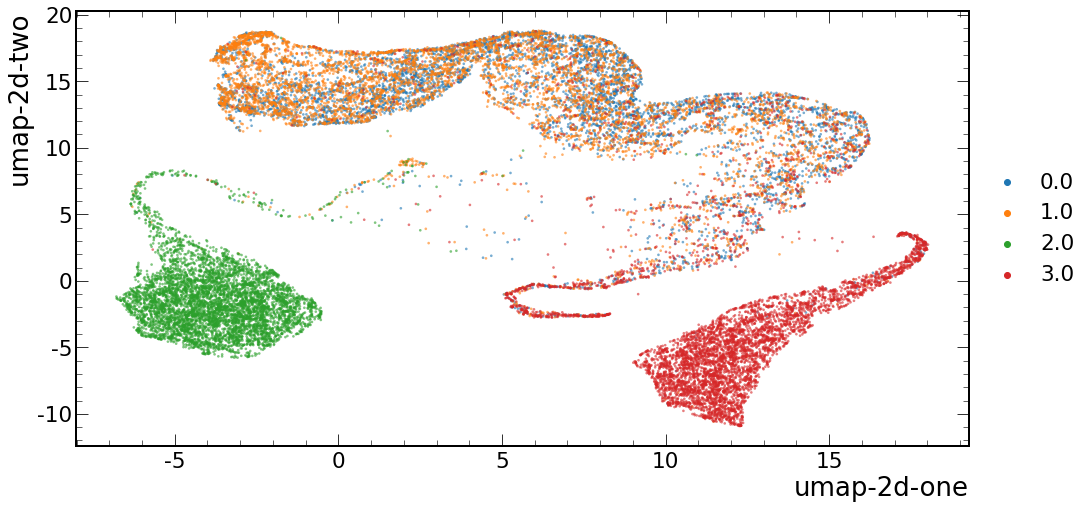

KeyboardInterrupt: 

<Figure size 1440x576 with 0 Axes>

In [ ]:
tsne_cl.plot_result_test()
plt.show()
plt.clf()
tsne_cl.plot_result_test(use_cut = True)
plt.show()
plt.clf()
tsne_cl.plot_result_test(cutted_events=True)

starting_tsne


/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


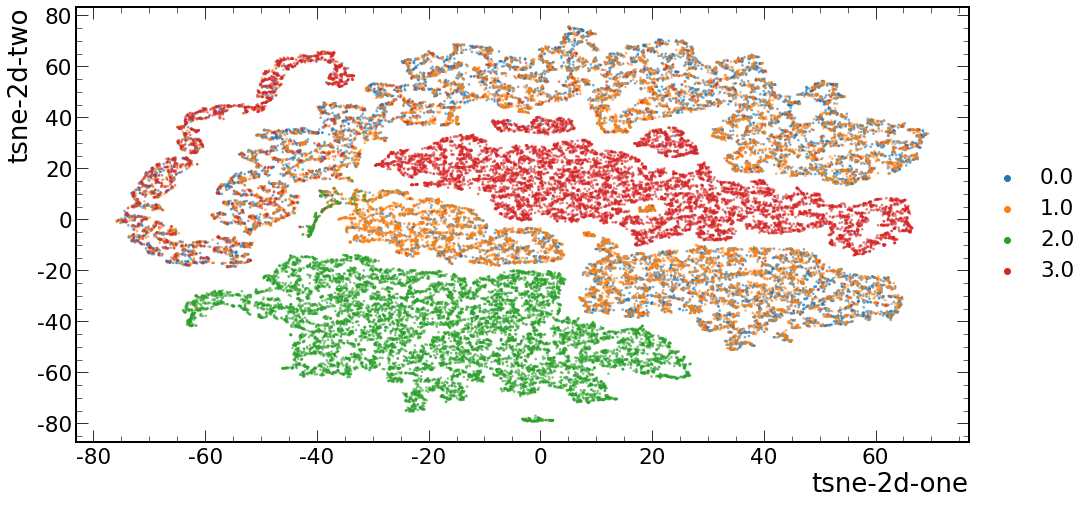

In [ ]:
tsne_cl_cut = TSNEclustering(lat_df = df_cut, sample_size= 10000)
tsne_cl_cut.perform_tsne()
tsne_cl_cut.plot_result()
small_df_cut = tsne_cl_cut.get_df()

(<Figure size 1440x576 with 6 Axes>, <AxesSubplot:>)

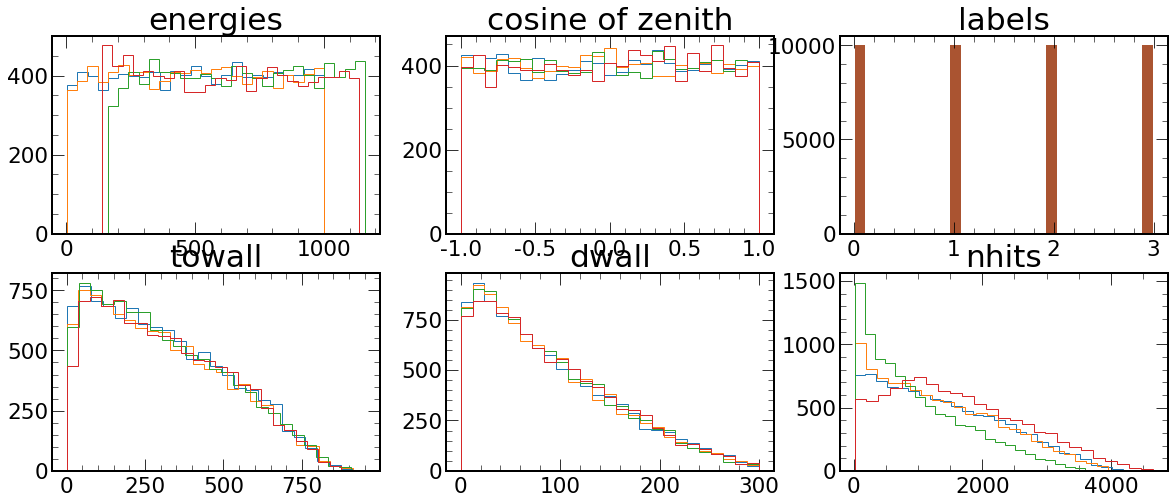

In [ ]:
dict_labels = {0.0 : 0.0, 1.0:1.0, 2.0:2.0, 3.0:3.0}
def plot_phyvar_hist(df,phyvars = ["energies", "zenith", "labels",'towall','dwall',"nhits"]):
    fig,axs = plt.subplots(2,3)
    for i in range(4):
        axs[0,0].hist(df["energies"].loc[df["labels"] == dict_labels[float(i)]], bins = 25, rwidth = 0.9, histtype = "step")
        axs[0,0].set_title("energies")
    for i in range(4):
        axs[0,1].hist(np.cos(df["zenith"].loc[df["labels"] == dict_labels[float(i)]]),  bins = 25, rwidth = 0.9, histtype = "step")
        axs[0,1].set_title("cosine of zenith")
    for i in range(4):
        axs[0,2].hist(df["labels"], bins = 25, rwidth = 0.9, alpha = 0.6)
        axs[0,2].set_title("labels")
    for i in range(4):
        axs[1,0].hist(df["towall"].loc[df["labels"] == dict_labels[float(i)]], bins = 25, rwidth = 0.9, histtype = "step")
        axs[1,0].set_title("towall")
    for i in range(4):
        axs[1,1].hist(df["dwall"].loc[df["labels"] == dict_labels[float(i)]],  bins = 25, rwidth = 0.9, histtype = "step")
        axs[1,1].set_title("dwall")
    for i in range(4):
        axs[1,2].hist(df["nhits"].loc[df["labels"] == dict_labels[float(i)]],  bins = 25, rwidth = 0.9, histtype = "step")
        axs[1,2].set_title("nhits")
    
    return fig, ax
plot_phyvar_hist(small_df)

/home/Antoine.m/my_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


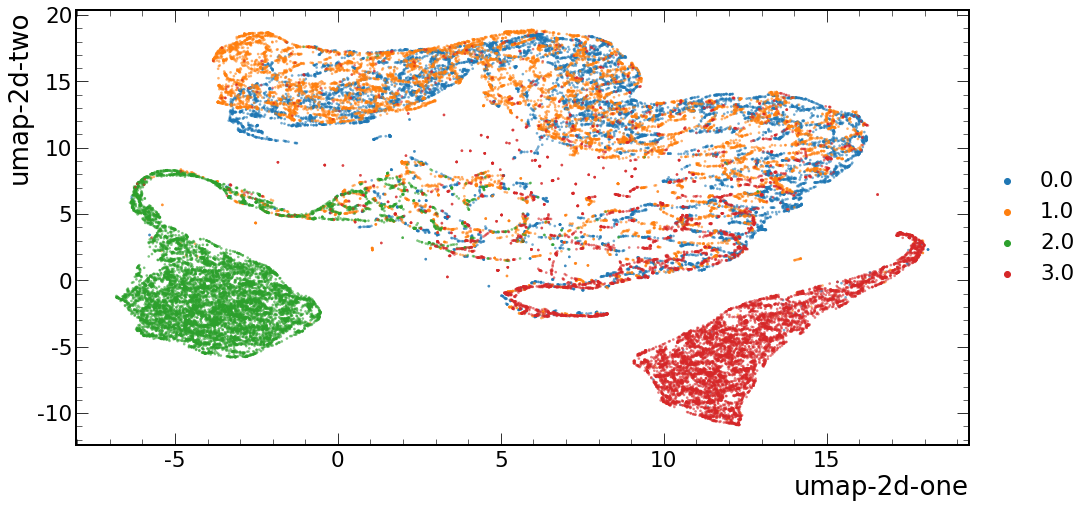

In [ ]:
tsne_cl.plot_result_train()

In [ ]:
def plot_phyvar_on_tsne_cut(df, center, radius, phyvars = ["energies", "zenith", "labels","towall", "dwall", "nhits"]):
    df = df.loc[np.abs(df["umap-2d-one"]-center[0]) < radius]
    df = df[np.abs(df["umap-2d-two"]-center[1]) <radius]
    fig, axs = plot_phyvar_hist(df,phyvars)
    fig.suptitle("Events in circle of center " + str(center) + ", radius " + str(radius))
    return df

index       z_0       z_1       z_2       z_3       z_4       z_5  \
1           1 -0.000136  0.000049 -0.000102  0.000091  0.000399  0.000782   
3           3  0.000130  0.000432  0.000586  0.000095  0.000606  0.000720   
4           4 -0.000190 -0.000041 -0.000062 -0.000137  0.000255  0.000179   
6           6 -0.000258  0.000624  0.000513 -0.000332  0.000625  0.000789   
7           7 -0.000337  0.000062  0.000284  0.000118  0.000183  0.000855   
...       ...       ...       ...       ...       ...       ...       ...   
9906  3534388  0.000292 -0.000324 -0.000183  0.000170  0.000954  0.001024   
9925  3534407 -0.000198  0.000004  0.000959  0.000012  0.000309  0.000900   
9975  3534457  0.000147  0.000202 -0.000181 -0.000273  0.000123  0.000350   
9976  3534458 -0.000397  0.000431  0.000872 -0.000698  0.000724  0.000831   
9985  3534467 -0.000529  0.000548 -0.000700  0.000147  0.000420  0.000315   

           z_6       z_7       z_8  ...  labels    energies    zenith  \
1    -0.112537 -0.001704 -0.001169  ...     0.0  858.386841  2.396345   
3    -0.192168 -0.000728 -0.000709  ...     0.0  818.989197  1.234110   
4    -0.167949 -0.001241 -0.000732  ...     0.0   60.207409  1.387609   
6    -0.190495 -0.001149 -0.000674  ...     0.0  624.871216  1.089706   
7    -0.174397 -0.001024 -0.000559  ...     0.0  255.925339  0.600086   
...        ...       ...       ...  ...     ...         ...       ...   
9906 -0.154615 -0.001222 -0.001044  ...     3.0  247.472519  2.095321   
9925 -0.289344 -0.000690 -0.000465  ...     3.0  843.828003  1.071424   
9975 -0.060947 -0.001388 -0.001103  ...     3.0  923.984436  0.930030   
9976 -0.200672 -0.000761 -0.000189  ...     3.0  720.301147  1.313569   
9985 -0.074495 -0.001868 -0.000955  ...     3.0  646.251221  2.595956   

       azimuth      towall       dwall  nhits    cut  umap-2d-one  umap-2d-two  
1    -1.009569  158.604782   99.009644    863   True    13.835171     7.679478  
3     1.671546  417.253355  121.900787   2902   True    11.721756    11.308278  
4     0.267695   78.351025   74.096588    240  False    14.735496    11.732809  
6    -2.173219  290.227371  174.569366   1744   True    13.324515    13.352041  
7     1.230309  221.641022   71.992889    749   True    15.565829    12.505920  
...        ...         ...         ...    ...    ...          ...          ...  
9906  0.135880  142.608190   85.002274    325   True    11.573323     9.585521  
9925  2.851813  606.730225   12.116486   2703  False    16.558302     6.471804  
9975 -1.388310  157.922274  124.233246   1400   True    12.570004     5.432319  
9976  3.063568  434.087217   24.884735   2530  False    13.574660    14.107363  
9985 -2.948566   63.825073   54.557449    521  False    11.734006     6.009258  

[5048 rows x 44 columns]

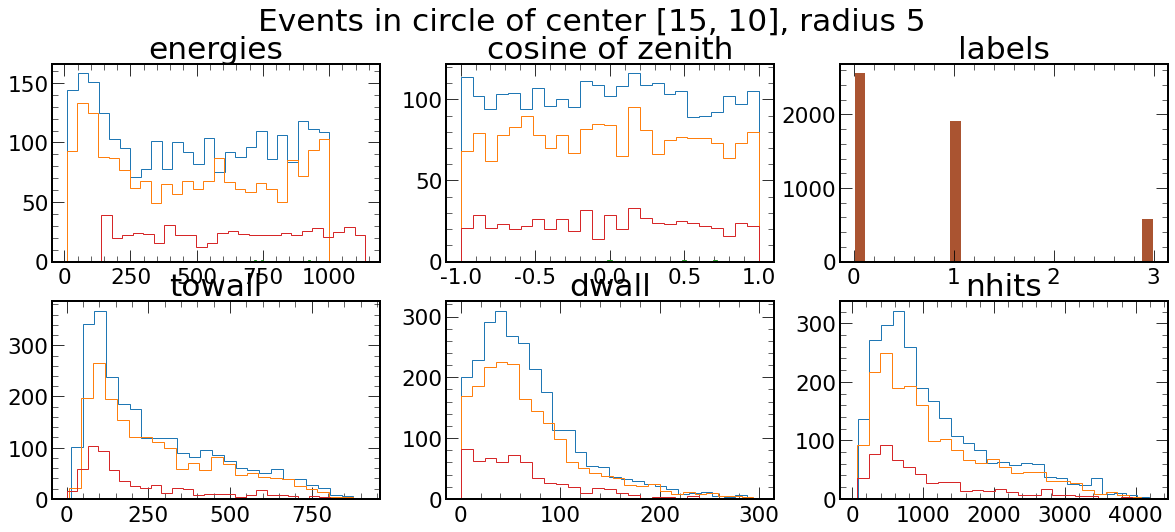

In [ ]:
plot_phyvar_on_tsne_cut(small_df, [15,10], 5)

In [ ]:
plot_phyvar_on_tsne_cut(small_df, [-20,-20] , 15)

index       z_0       z_1       z_2       z_3       z_4       z_5  \
44         44  0.000258  0.000555  0.001975  0.000063  0.000202  0.000509   
47         47 -0.000450 -0.000005  0.001012 -0.000271 -0.000066  0.000312   
53         53  0.000742  0.000416 -0.000647 -0.000010  0.000254  0.000095   
59         59 -0.000205 -0.000398  0.002947  0.000724 -0.001788 -0.000175   
68         68  0.000606 -0.000092 -0.000060  0.000311  0.000910  0.000192   
...       ...       ...       ...       ...       ...       ...       ...   
9790  3534272  0.000119  0.000226  0.000129  0.000045  0.000732 -0.000416   
9910  3534392  0.000412  0.000362  0.000135  0.000133 -0.000189  0.000646   
9945  3534427  0.000129 -0.001385  0.002561 -0.000309  0.001289  0.001675   
9979  3534461 -0.000562  0.000369 -0.000297 -0.000146  0.001066  0.000588   
9986  3534468  0.000101 -0.000480 -0.000076  0.000543  0.000127 -0.001112   

           z_6       z_7       z_8  ...  labels     energies    zenith  \
44   -0.201105  0.002010  0.003008  ...     0.0   440.782715  0.487488   
47   -0.021677  0.001848  0.002062  ...     0.0     6.490748  1.068554   
53    0.163052  0.000688  0.000815  ...     0.0   982.232727  2.936945   
59   -0.081738 -0.000121  0.000413  ...     0.0    94.565552  1.526997   
68   -0.091022 -0.000466  0.000168  ...     0.0   907.116821  2.309207   
...        ...       ...       ...  ...     ...          ...       ...   
9790 -0.087999 -0.000462 -0.000226  ...     3.0   305.924530  2.445256   
9910 -0.040414  0.000491  0.001028  ...     3.0  1011.277100  1.342893   
9945  0.103694  0.003377  0.005012  ...     3.0  1085.609009  2.116209   
9979 -0.175811 -0.001835 -0.001129  ...     3.0   723.402039  1.008095   
9986  0.053707  0.000161  0.000237  ...     3.0   969.778076  1.508428   

       azimuth      towall       dwall  nhits    cut  umap-2d-one  umap-2d-two  
44   -1.627631   69.948761   61.800598    348  False    -0.150700     5.727527  
47    0.679560  654.182235  188.663818     51   True     4.930924     3.624806  
53   -0.793795    4.269958    3.762726     38  False     5.252272     1.468963  
59   -0.086163   49.298654   29.173462    219  False     1.206079     4.630845  
68    1.356051   25.960785   15.254395    220  False     4.710305     6.356945  
...        ...         ...         ...    ...    ...          ...          ...  
9790 -0.613734   76.321402   42.392365     45  False     2.828480     5.537898  
9910  2.222330   88.740606   27.221283    218  False     3.272190     3.927857  
9945  0.069490   28.028806    5.929962     57  False     3.523527     2.118989  
9979 -0.714117  379.781738  202.603333   2319   True     4.750716     8.839102  
9986  0.626669    8.860287    3.097809     37  False     3.884740     2.321239  

[3559 rows x 44 columns]

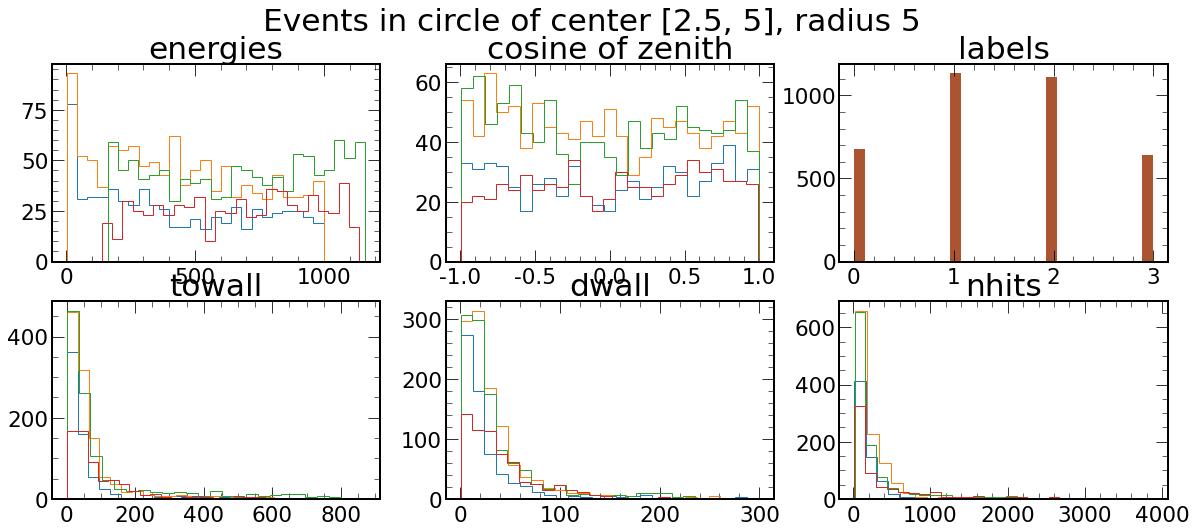

In [ ]:
plot_phyvar_on_tsne_cut(small_df, [2.5,5] , 5)

<AxesSubplot:>

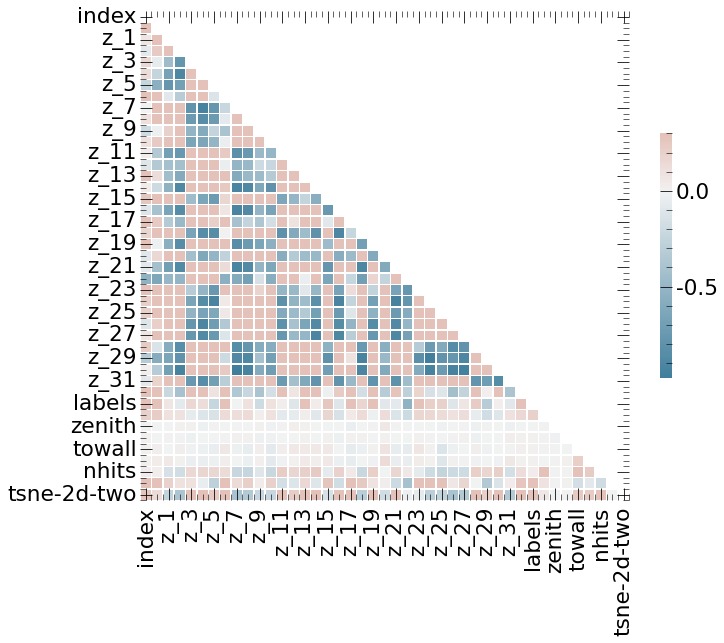

In [ ]:
import seaborn as sns
# Compute the correlation matrix
corr = small_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Plot training progression

In [ ]:
# fig, ax1, ax2, = resnet_run.plot_training_progression(legend=None, fig_size=(16,10), title=resnet_run.run_label)
# leg_fig, leg_ax = plot_legend((ax1, ax2))

## Plot results

### Plot histograms of the predicted probabilities
For electron vs muon probabilities, in a 4-class model with gammas (which are also considered electron-like) we need to combine the electron and gamma softmaxes to get the electron-like probability.
The discriminator method used below automatically calulates the signal probability from the softmax values of the given signal and background labels.

In [ ]:
help(WatChMaLClassification.discriminator)

Help on function discriminator in module analysis.classification:

discriminator(self, signal_labels, background_labels)
    Return a discriminator with appropriate scaling of softmax values from multi-class training, given the set of
    signal and background class labels. For each event, the discriminator is the sum the signal softmax values
    normalised by the sum of signal and background softmax values.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels corresponding to signal classes. Can be either a single label or a sequence of labels.
    background_labels: int or sequence of ints
        Set of labels corresponding to background classes. Can be either a single label or a sequence of labels.
    
    Returns
    -------
    np.ndarray
        One-dimensional array of discriminator values, with length equal to the number of events in this run.



In [ ]:
e_labels = [0,1]
mu_labels = [3]
e_probabilities_resnet = resnet_run.discriminator(e_labels, mu_labels)
mu_probabilities_resnet = resnet_run.discriminator(e_labels, mu_labels)
e_probabilities_vmdls = vmdls_run.discriminator(e_labels, mu_labels)
mu_probabilities_vmdls = vmdls_run.discriminator(e_labels, mu_labels)

Text(0.5, 1.0, 'Resnet gamma/electron discriminator')

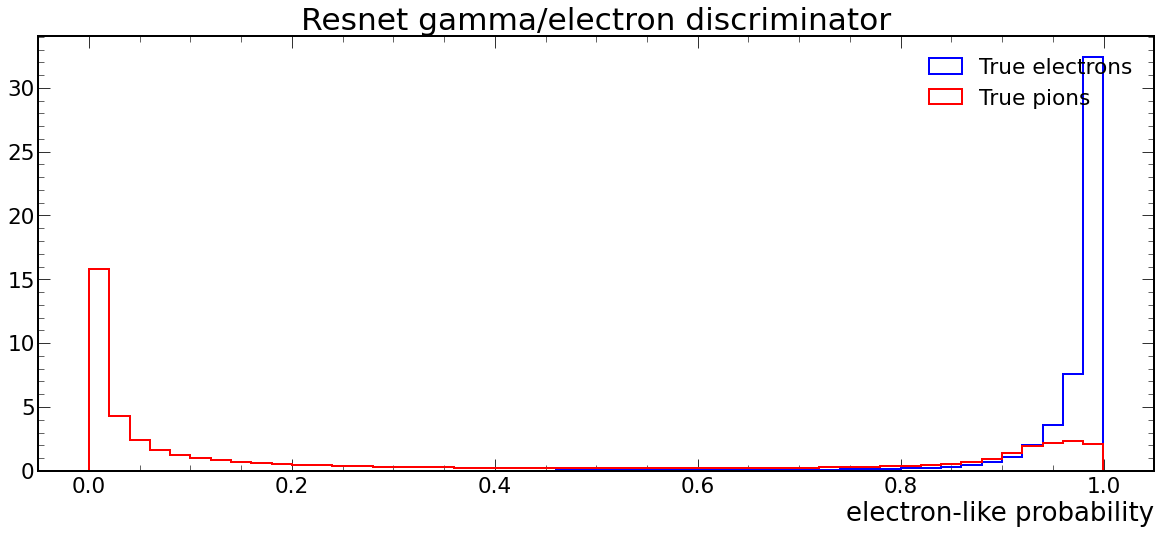

In [ ]:
fig, ax = plt.subplots()
ax.hist(e_probabilities_resnet[h5_electrons], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(e_probabilities_resnet[h5_pions], density=True, histtype='step', lw=2, color='red', bins=50, label='True pions')
ax.set_xlabel("electron-like probability")
ax.legend(loc='best')
plt.title("Resnet gamma/electron discriminator")

Text(0.5, 1.0, 'VMDLS gamma/electron discriminator')

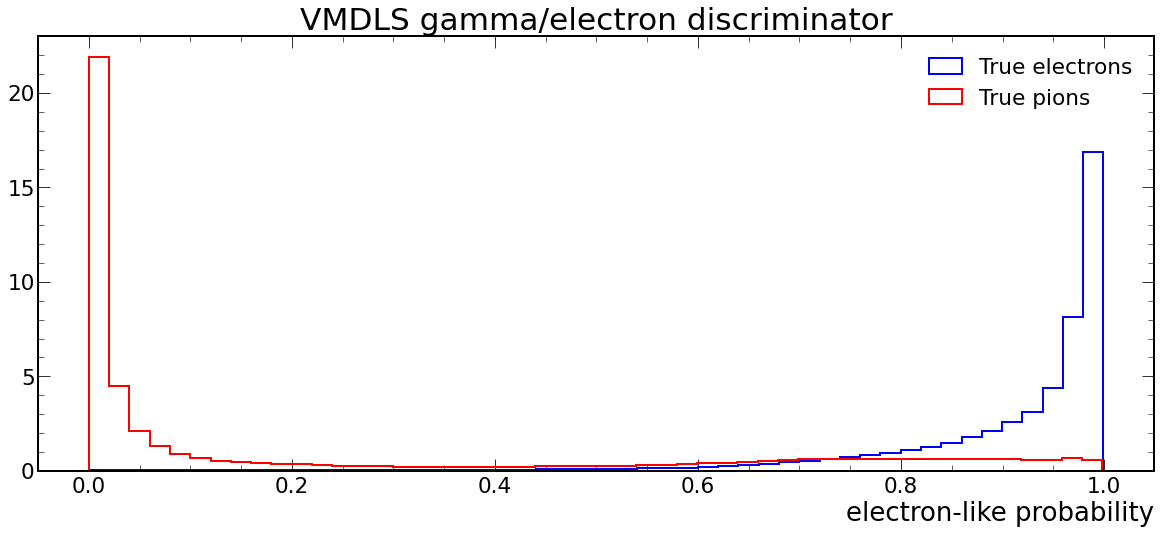

In [ ]:
fig, ax = plt.subplots()
ax.hist(e_probabilities_vmdls[h5_electrons], density=True, histtype='step', lw=2, color='blue', bins=50, label='True electrons')
ax.hist(e_probabilities_vmdls[h5_pions], density=True, histtype='step', lw=2, color='red', bins=50, label='True pions')
ax.set_xlabel("electron-like probability")
ax.legend(loc='best')
plt.title("VMDLS gamma/electron discriminator")

### ROC curve for electron signal vs muon rejection

The `plot_rocs` function allows plotting overlaid ROC curves for a chosen signal and background classification.

We plot using a few different formats for viewing the ROC data.

Note that in several of the plotting functions, we pass a list of runs (here just containing a single run, i.e. `[resnet_run]`). To make plots comparing multiple classification runs, for example with different network architectures or hyperparameters, you can simply replace this with a list containing more than one run.

<Figure size 720x576 with 0 Axes>

findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


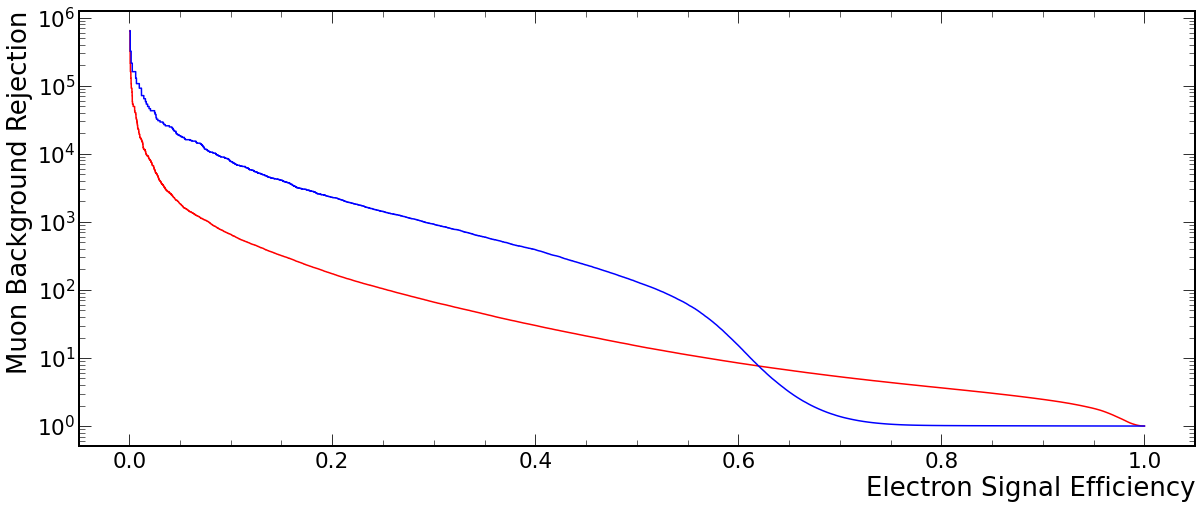

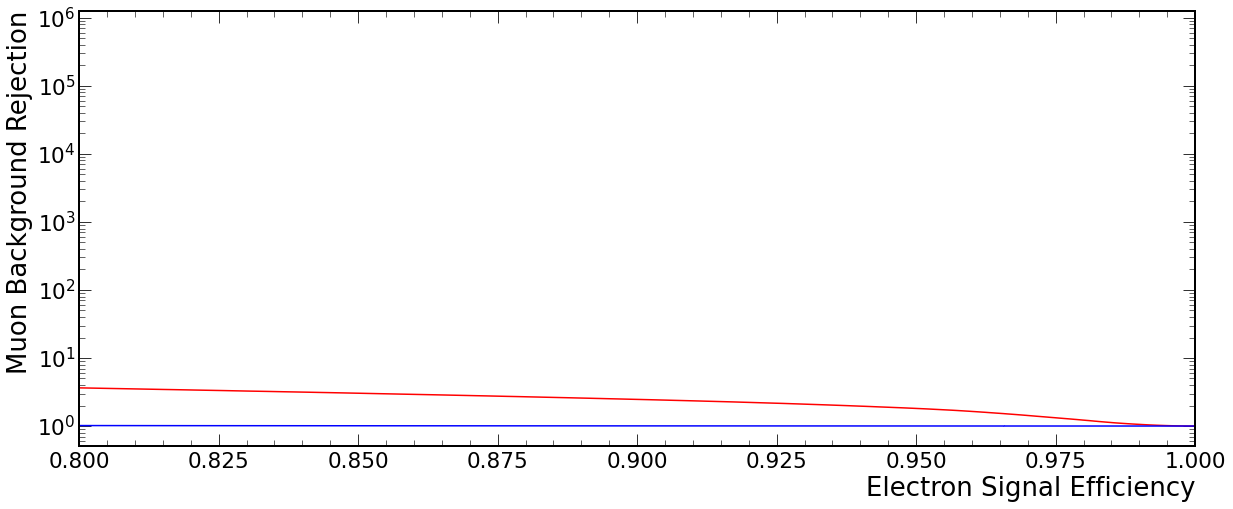

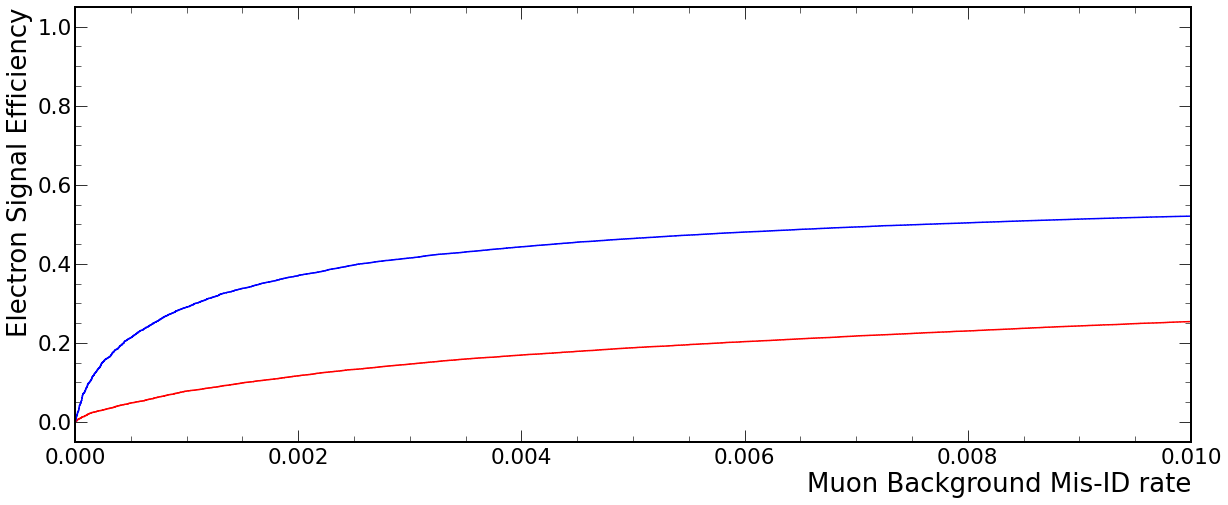

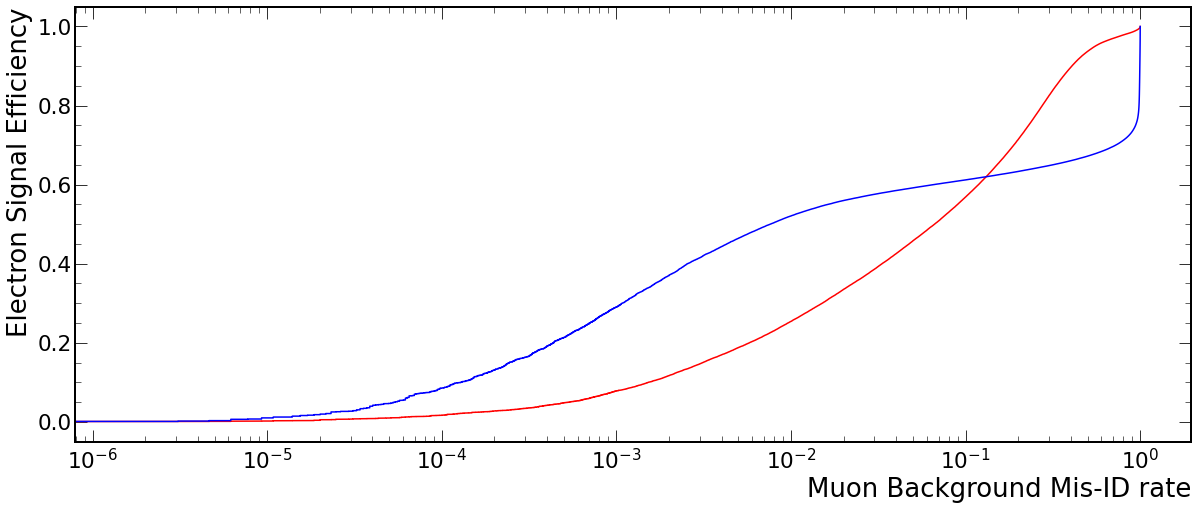

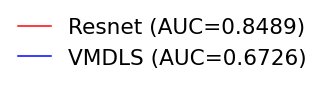

In [ ]:
new_fig = plt.figure(figsize = (10,8))
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', legend=None)
new_fig.axes.append(ax)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Electron Signal Efficiency", y_label="Muon Background Rejection", mode='rejection', x_lim=(0.8,1), legend=None)
new_fig.axes.append(ax)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_lim=(0,0.01), legend=None)
new_fig.axes.append(ax)
fig, ax = plot_rocs([resnet_run, vmdls_run], e_labels, mu_labels, x_label="Muon Background Mis-ID rate", y_label="Electron Signal Efficiency", mode='efficiency', x_log=True, legend=None)
new_fig.axes.append(ax)
l_fig, l_ax = plot_legend(ax)
plt.show()
new_fig.show()

###  for fixed 0.1% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds that reject 99.9% of muons and apply cut to all events

In [ ]:
help(WatChMaLClassification.cut_with_fixed_efficiency)

Help on function cut_with_fixed_efficiency in module analysis.classification:

cut_with_fixed_efficiency(self, signal_labels, background_labels, efficiency, selection=None, select_labels=None, return_threshold=False)
    Generate array of boolean values indicating whether each event passes a cut defined such that a fixed proportion
    of the selected events pass the cut.
    After taking the subset of `discriminator_values` defined by `selection`, the threshold discriminator value is
    found such that the proportion that are above the threshold is equal to `efficiency`. This cut threshold is then
    used to apply the cut to all events (not just those selected by `selection`) and an array of booleans is
    returned for whether each discriminator value is above the threshold of its corresponding bin. The cut result is
    also stored for use in plotting efficiency profiles.
    
    Parameters
    ----------
    signal_labels: int or sequence of ints
        Set of labels correspond

In [ ]:
muon_rejection = 0.999
muon_efficiency = 1-muon_rejection
resnet_run.cut_with_fixed_efficiency(e_labels, mu_labels, muon_efficiency, select_labels=mu_labels)
vmdls_run.cut_with_fixed_efficiency(e_labels, mu_labels, muon_efficiency, select_labels=mu_labels)

ValueError: There are zero selected events so cannot calculate a cut with any efficiency.

### Plot signal efficiency against true momentum, dwall, towall, zenith, azimuth

In [ ]:
help(plot_efficiency_profile)

Help on function plot_efficiency_profile in module analysis.classification:

plot_efficiency_profile(runs, binning, selection=None, select_labels=None, ax=None, fig_size=None, x_label='', y_label='', legend='best', y_lim=None, **plot_args)
    Plot binned efficiencies for a cut applied to a number of classification runs.
    Each run should already have had a cut generated, then in each bin the proportion of events passing the cut is
    calculated as the efficiency and plotted. A selection can be provided to use only a subset of all the values. The
    same binning and selection is applied to each run.
    
    Parameters
    ----------
    runs: sequence of ClassificationRun
        Sequence of runs to plot
    binning: (np.ndarray, np.ndarray)
        Array of bin edges and array of bin indices, returned from `analysis.utils.binning.get_binning`.
    selection: indexing expression, optional
        Selection of the values to use in calculating the efficiencies (by default use each r

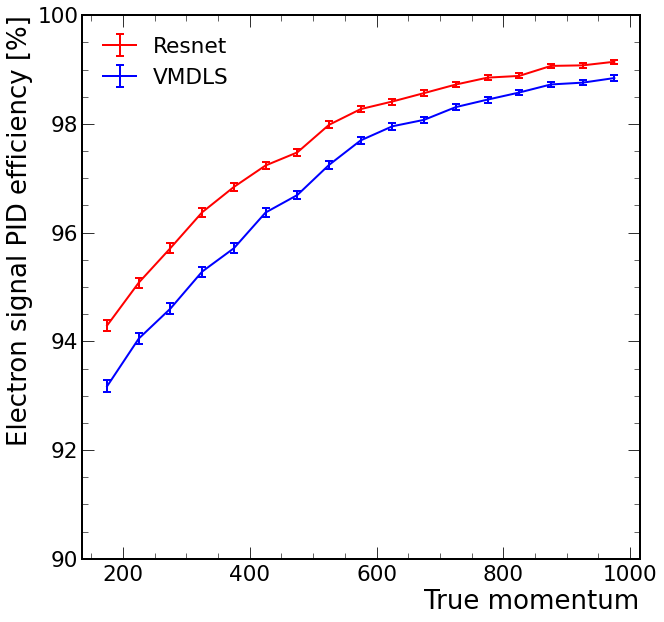

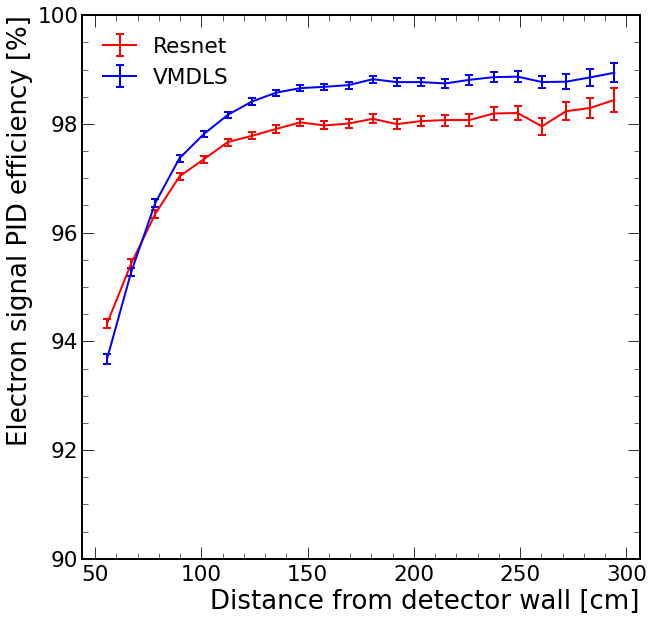

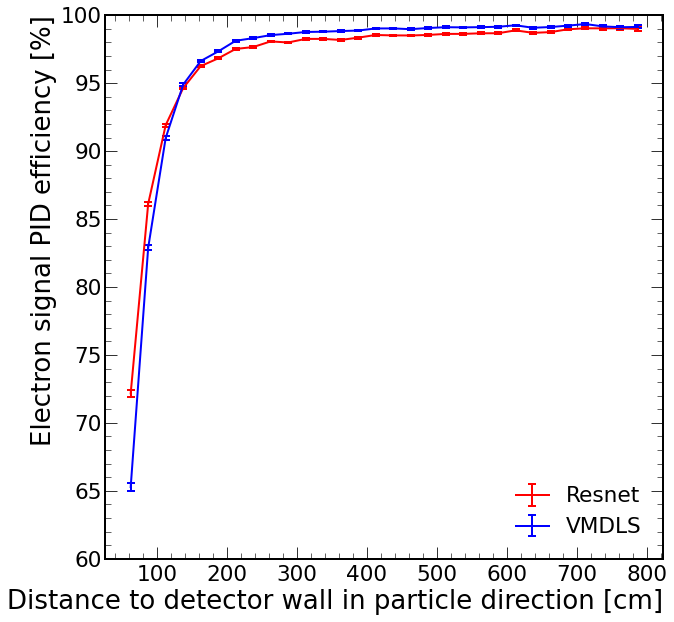

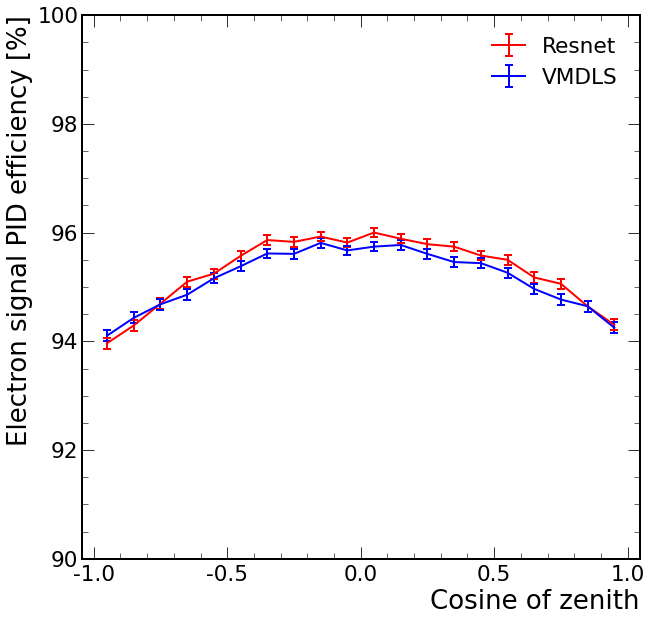

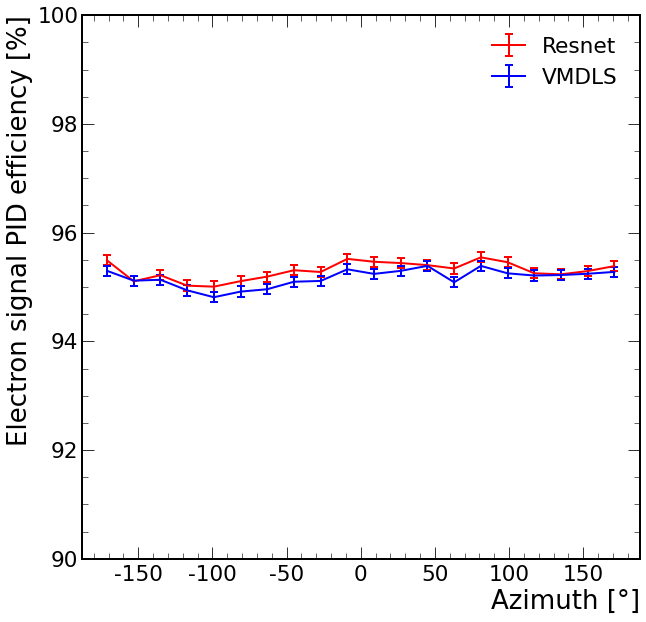

In [ ]:
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], mom_binning, select_labels=e_labels, x_label="True momentum", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(90,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], dwall_binning, select_labels=e_labels, x_label="Distance from detector wall [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(90,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], towall_binning, select_labels=e_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(60,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], cos_zenith_binning, select_labels=e_labels, x_label="Cosine of zenith", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(90,100))
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], azimuth_binning, select_labels=e_labels, x_label="Azimuth [°]", y_label="Electron signal PID efficiency [%]", errors=True, x_errors=False, y_lim=(90,100))

### Plot background mis-ID against true momentum, dwall, towall, zenith, azimuth

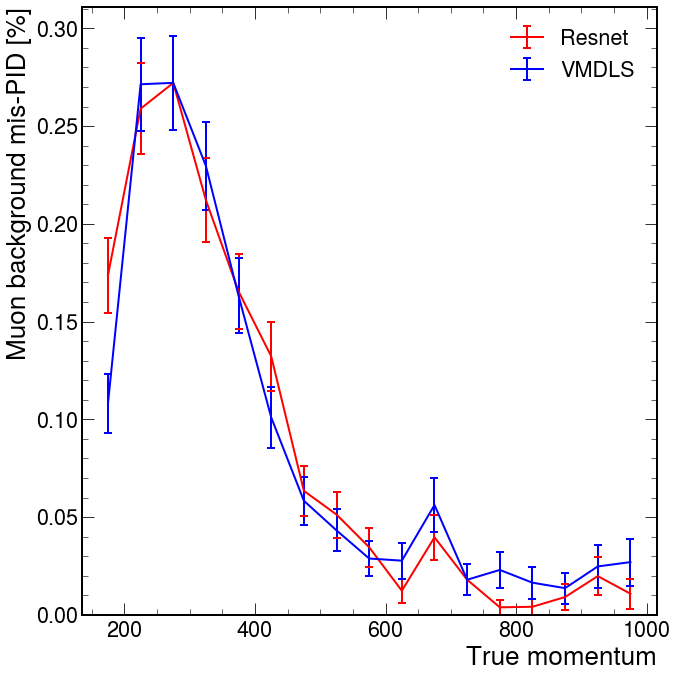

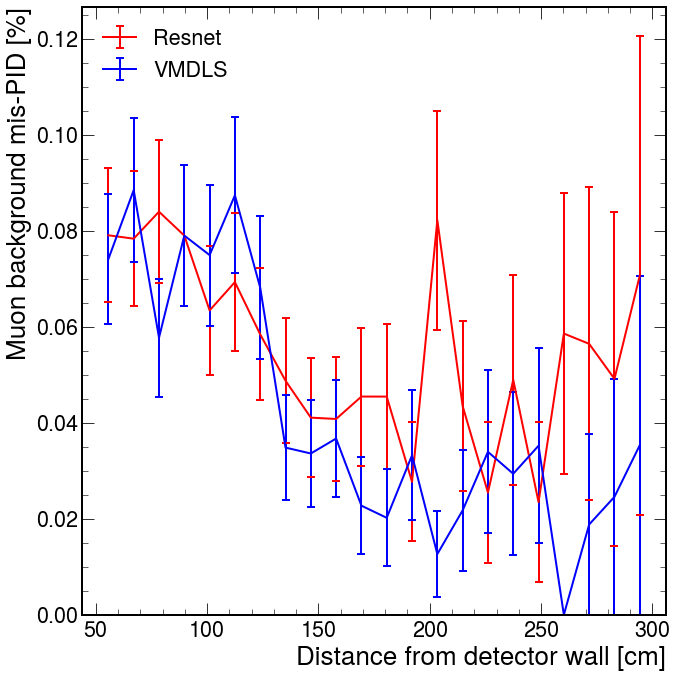

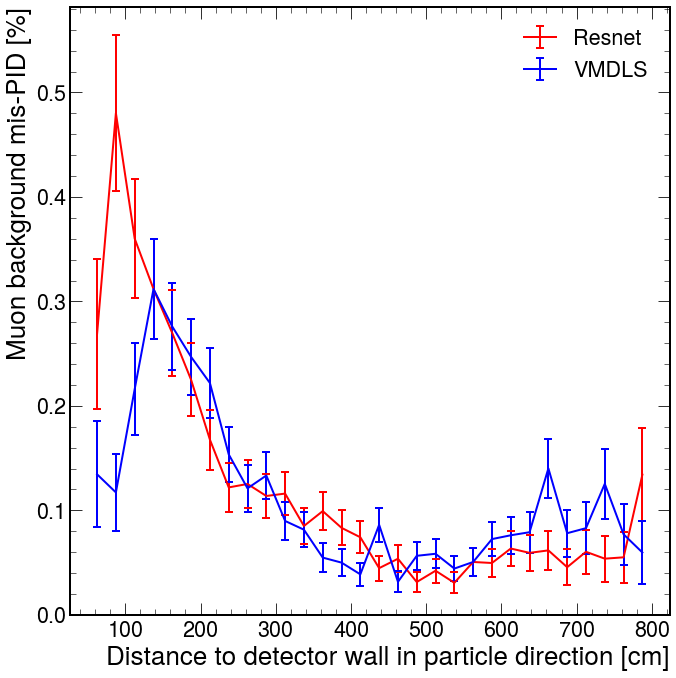

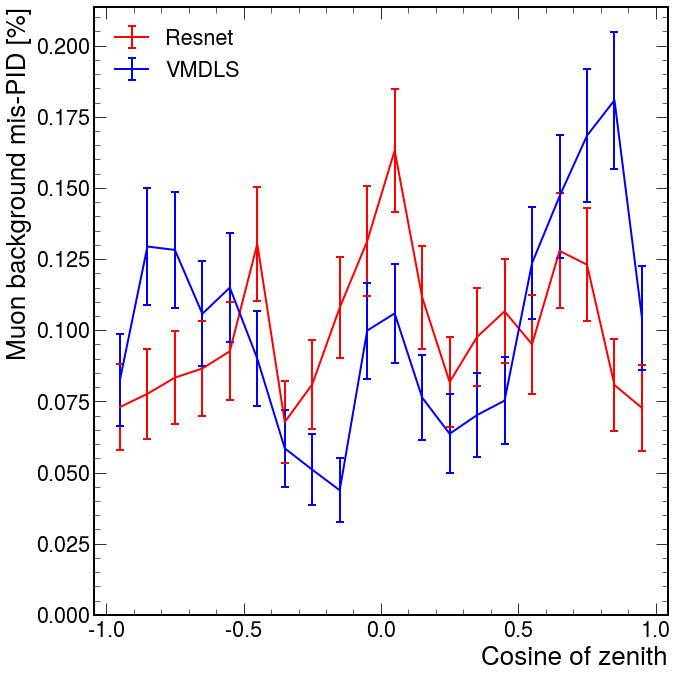

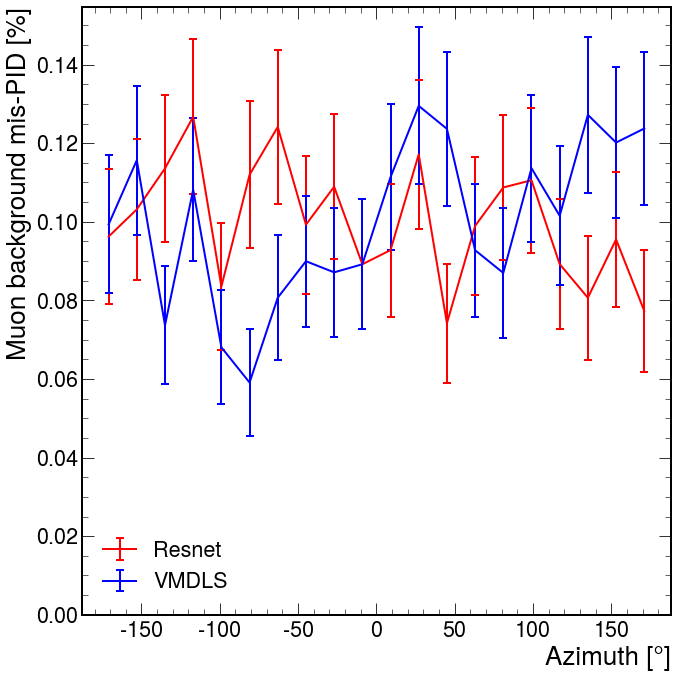

In [ ]:
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], mom_binning, select_labels=mu_labels, x_label="True momentum", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run,vmdls_run], dwall_binning, select_labels=mu_labels, x_label="Distance from detector wall [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run,  vmdls_run], towall_binning, select_labels=mu_labels, x_label="Distance to detector wall in particle direction [cm]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run, vmdls_run ], cos_zenith_binning, select_labels=mu_labels, x_label="Cosine of zenith", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)
fig, ax = plot_efficiency_profile([resnet_run, vmdls_run], azimuth_binning, select_labels=mu_labels, x_label="Azimuth [°]", y_label="Muon background mis-PID [%]", errors=True, x_errors=False, y_lim=0)